<a href="https://colab.research.google.com/github/JamesPeralta/Machine-Learning-Algorithms/blob/master/Screen-time%20Calculator/Screen_Time_Of_Actors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Screen Time Of Actors
### In this notebook I will implement a Neural Network that calculates the time screen time of actors in any video.

### Imports

In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
import tensorflow as tf

from google.colab import drive
import os

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset_directory = '/content/drive/My Drive/Datasets/ScreenTimeCalculator/train'

os.chdir(dataset_directory)

In [4]:
os.listdir()

['Tom and jerry.mp4', 'mapping.csv']

## Step 1: Read the video, extract frames from it and save them as images
* We will load the video
* Convert it to frames

In [5]:
count = 0
videoFile = "Tom and jerry.mp4"

cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path

frameRate = cap.get(cv2.CAP_PROP_FPS) # Frame rate

x=1
while(cap.isOpened()):
  
    frameId = cap.get(1) #current frame number
    
    ret, frame = cap.read()
    
    if (ret != True):
        break
    
    # Mod the frame number by the framerate
    # We will get 1 frame every 2 seconds
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
        
cap.release()
print ("Done!")

Done!


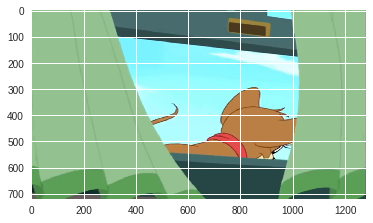

In [6]:
img = plt.imread('frame1.jpg')   # reading image using its name
plt.imshow(img)

## Step 2: Label a few images for training the model
* This will be a multi-class classification problem. With the following classes:
 *  0 – neither JERRY nor TOM
 *  1 – for JERRY
 *  2 – for TOM
 
 This dataset has already been labeled so we will just pull in the csv file with the labels

### Vectorize the video frames

In [7]:
data = pd.read_csv('mapping.csv') # Read in the csv file
data.head()      # printing first five rows of the file

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


In [0]:
X = [ ]     # creating an empty array

for img_name in data.Image_ID:
    img = plt.imread(img_name) # Read the image as an array
    X.append(img)  # storing each image in array X
    
X = np.array(X)    # converting list to array

In [12]:
print(X.shape)

(298, 720, 1280, 3)


### Vectorize the Output labels

In [0]:
y = data.Class
dummy_y = np_utils.to_categorical(y)    # one hot encoding Classes

In [0]:
print(dummy_y)

### We will be using a VGG16 pretrained model which takes an input image of shape (224 X 224 X 3)
### Since our images are a different size, we need to reshape all of them
### We can use the resize() function of skimage.transform

In [15]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [16]:
print(X.shape)

(298, 224, 224, 3)


### Now that the images have been reshaped to the correct size we will still need to do one more step. This step is to preprocess is to the other model's requirments otherwise it will not perform well enough

In [0]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data

### Now we need to create a train, dev set

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)    # preparing the validation set

## Step 3: Building the model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, InputLayer, Dropout

### Load Pretrained model

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [21]:
print(base_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Make predictions using the model to extract the features

In [22]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

((208, 7, 7, 512), (90, 7, 7, 512))

In [0]:
X_train = X_train.reshape(208, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(90, 7*7*512)

In [0]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

### Building the model

In [0]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(3, activation='softmax'))    # output layer

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


In [27]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.38.83.154:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2823724207644815233)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5278392186776635803)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13046835079934525446)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

### Compiling the model

In [0]:
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['acc']
)

### Training the model

In [29]:
tpu_model.fit(train, 
          y_train, 
          epochs=100, 
          validation_data=(X_valid, y_valid))

Train on 208 samples, validate on 90 samples
Epoch 1/100
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(4, 25088), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(4, 3), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_2
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.9198460578918457 secs
INFO:tensorflow:Setting weights on TPU model.
160/208 [======================>.......] - ETA: 1s - loss: 1.1190 - acc: 0.4688INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(2, 25088), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(2, 3), dtype=tf.float32,

In [30]:
tpu_model.save_weights('/content/drive/My Drive/Datasets/ScreenTimeCalculator/test/tpu_model.h5')

INFO:tensorflow:Copying TPU weights to the CPU


## Step 4: Using the Model (Make predictions)
### Now that we have a Model, we will now calculate the screen time of a video

### Extract frames from videos

In [0]:
dataset_directory = '/content/drive/My Drive/Datasets/ScreenTimeCalculator/test'

os.chdir(dataset_directory)

In [32]:
os.listdir()

['Tom and Jerry 3.mp4', 'test.csv', 'tpu_model.h5']

In [33]:
count = 0
videoFile = "Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


### Preprocess frames
* Retreive videos and resize them

In [34]:
test = pd.read_csv('test.csv')

test.head()

,Image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [0]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread(img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [68]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int) # Resize only works on a np.array
    test_image.append(a)
test_image = np.array(test_image)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [69]:
test_image.shape

(186, 224, 224, 3)

In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

In [0]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [72]:
test_image.shape

(186, 25088)

## Step 5: Calculate the screen time of both TOM and JERRY

In [0]:
cpu_model = Sequential()
cpu_model.add(InputLayer((7*7*512,)))    # input layer
cpu_model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
cpu_model.add(Dense(3, activation='softmax'))    # output layer

cpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['acc']
)

In [0]:
cpu_model.load_weights('./tpu_model.h5')

In [77]:
predictions = cpu_model.predict_classes(test_image)
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 9 seconds
The screen time of TOM is 102 seconds
